#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# set random seed
np.random.seed(12345)

#### Loading Data

Dataset: PIMA Indian Diabetes Database\
Source: Kaggle (https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

Variables:
1. Preg: Number of times pregnant
2. Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. BP: Diastolic blood pressure (mm Hg)
4. skinThick: Triceps skin fold thickness (mm)
5. Insulin: 2-Hour serum insulin (mu U/ml)
6. BMI: Body mass index (weight in kg/(height in m)^2)
7. DPF: Diabetes pedigree function
8. Age: Age (Years)
9. Class: Class variable 0, 1

In [3]:
# Loading Dataset
data_filepath = "pima-indians-diabetes.csv" # please change the location as per the filepath of the dataset
# header_list = ["Preg", "Glucose", "BP", "skinThick", "Insulin", "BMI", "DPF", "Age", "Class"]
diabetes_df = pd.read_csv(data_filepath) 

In [4]:
# Top 5 rows of the dataset
diabetes_df.head()

,Preg,Glucose,BP,skinThick,Insulin,BMI,DPF,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## RandomForestClassifier on original data - 768 data points, 8 features

In [5]:
# Features are all variables except the target Class
# Labels are Y variables - binary variables with values 0 or 1
features_df = diabetes_df.drop(['Class'], axis=1) #everything but the Class column
labels_df = diabetes_df["Class"] #the Class column

In [65]:
# Create train-test split 80:20 on original data
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df,  test_size=0.20, random_state=12345)

In [66]:
# Scaling the numerical features
numerical_features = ['Preg', 'Glucose', 'BP', 'skinThick', 'Insulin', 'BMI', 'DPF', 'Age']
stand_scal = StandardScaler()
X_train = stand_scal.fit_transform(X_train[numerical_features])
X_test = stand_scal.transform(X_test[numerical_features])

In [67]:
# RandomForest Classifier
RF = RandomForestClassifier(
    n_estimators=50, 
    random_state=12345,
    criterion='entropy')
RF_model = RF.fit(X_train, y_train)
y_pred = RF_model.predict(X_test)

In [68]:
print("Accuracy of the RandomForest Classifier on original data is: {:2%}".format(round(accuracy_score(y_test, y_pred),4)))

Accuracy of the RandomForest Classifier on original data is: 80.520000%


#### The output shows that when using all 8 features, our algorithm achieves an accuracy of 80.52% for correct prediction of whether or not a person is diabetic. That’s not great, but it’s not too bad for a quickly trained model with a limited dataset.

# **Dimensionality Reduction with PCA**

In [15]:
# Before we utilize the PCA algorithm we need to scale the numerical features
# PCA operates only on the X variables, not on the y variable, so we ideally exclude the y variable from scaling
numerical_features = ['Preg', 'Glucose', 'BP', 'skinThick', 'Insulin', 'BMI', 'DPF', 'Age']
scaler = StandardScaler()
scaler.fit(diabetes_df[numerical_features]) #
diabates_scaled_features = scaler.transform(diabetes_df[numerical_features]) #creates a n-dimensional numpy array which has to be stored as a dataframe 

# Scaling a binary variable does not make any statistical sense unless we want numerical stability - so we can ignore binary variables in scaling
# https://stats.stackexchange.com/questions/59392/should-you-ever-standardise-binary-variables

In [18]:
# creating a dataframe of scaled features from the n-d numpy array after scaling
diabates_scaled_features_df = pd.DataFrame(data=diabates_scaled_features,
                                columns=numerical_features)

diabates_scaled_features_df.shape

(768, 8)

## Identifying the ideal number of components

* Since we want to reduce the dimensionality of the data, we typically limit the number of components in PCA to the maximum number of features in the data - 1
* In this example, we have 8 input features, so we first do a PCA with n_components = 8 - 1 = 7
* Scikit-learn implements PCA this way:
    * if n_components = None, n_components = min(n_samples, n_features) - 1
    * so, if n_components is not mentioned,
    * the PCA model will be built with the n_components = min(768, 8) - 1 = 8 - 1 = 7
* Random_state locks the initial vector that starts the underlying optimization routine
    * If random_state is not specified, the PCA may not be reproduced the same way each time it is run

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [32]:
# Building a PCA model with n_components = number of columns in the features dataframe
number_of_features = len(diabates_scaled_features_df.columns)
pca = PCA(
    n_components=number_of_features-1, # could also specify None
    random_state=12345
    )

pca.fit_transform(diabates_scaled_features_df)

array([[ 1.06850273,  1.23489499,  0.09592984, ..., -0.10998491,
         0.35718251,  0.85882133],
       [-1.12168331, -0.73385167, -0.71293816, ..., -0.38950719,
        -0.40632934,  0.75703403],
       [-0.39647671,  1.59587594,  1.76067844, ...,  0.90647385,
        -0.04001752, -1.15299029],
       ...,
       [-0.28347525,  0.09706503, -0.07719194, ..., -0.52300926,
        -0.53826993, -0.33556321],
       [-1.06032431,  0.83706234,  0.42503045, ...,  0.95759303,
         0.15330712,  1.18030813],
       [-0.83989172, -1.15175485, -1.00917817, ..., -0.08265082,
        -0.15009639,  0.24523536]])

Once we have our PCA done, we can extract the proportion of variance explained and the eigenvalues as

In [33]:
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

The proportion of variance explained by each principal component is shown in the screen plot below:


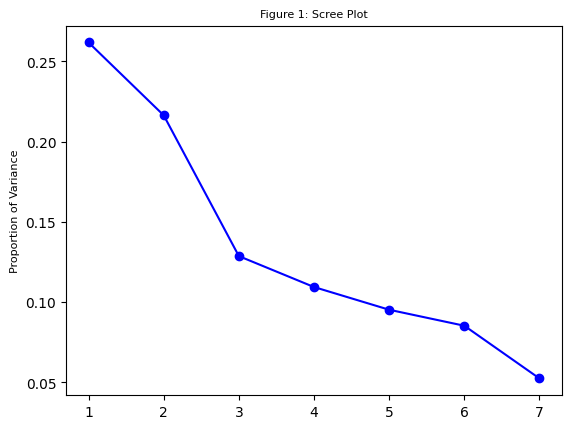

In [27]:
print("The proportion of variance explained by each principal component is shown in the screen plot below:")
PC_numbers = np.arange(pca.n_components_) + 1

plt.plot(PC_numbers,
         prop_var,
         'bo-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

Elbow Rule criterion:
* Identify the component number after which the scree plot tends to flatten out (look at the slope - increase in proportion variance explained with unit increase in number of components)
* Considering the elbow rule, we can see that the first 3 components are to be selected, as after the 3rd component, the scree plot tends to flatten


Another way to look at proportion of variance plot, is a general heuristic to consider components so that the total proportion of variance explained is greater than 80%

Ref: 
1. https://sanchitamangale12.medium.com/scree-plot-733ed72c8608
2. https://bioturing.medium.com/how-to-read-pca-biplots-and-scree-plots-186246aae063

We can also look at the eigenvalues as:


The eigvenvalues associated with each principal component is shown in the plot below:


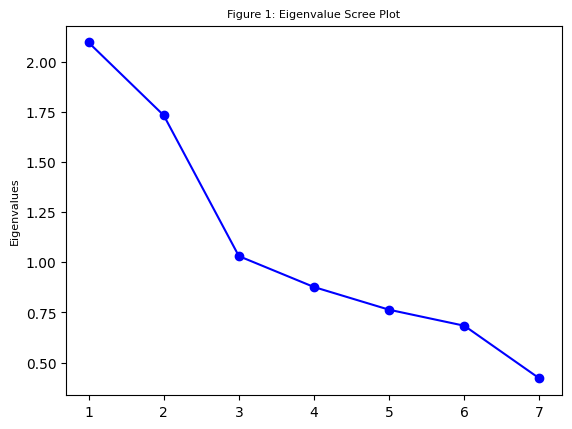

In [34]:
print("The eigvenvalues associated with each principal component is shown in the plot below:")
PC_numbers = np.arange(pca.n_components_) + 1

plt.plot(PC_numbers,
         eigenvalues,
         'bo-')
plt.title('Figure 1: Eigenvalue Scree Plot', fontsize=8)
plt.ylabel('Eigenvalues', fontsize=8)
plt.show()

Kaiser criterion:
* Identify the components who have eigenvalues greater than 1 - eigenvalues are proxy for information contained in that dimension - higher than 1 indicates that these dimensions are most informative
* Considering the Kaiser criterion, we can see that the first 3 components are to be selected, as after the 3rd component, the eigenvalues are below 1

Ref: https://docs.displayr.com/wiki/Kaiser_Rule

## Re-run PCA with 3 components

In [37]:
pca_new = PCA(
    n_components=3,
    random_state=12345
    )

top3_pca_features = pca_new.fit_transform(diabates_scaled_features_df)
top3_pca_features

array([[ 1.06850273,  1.23489499,  0.09592984],
       [-1.12168331, -0.73385167, -0.71293816],
       [-0.39647671,  1.59587594,  1.76067844],
       ...,
       [-0.28347525,  0.09706503, -0.07719194],
       [-1.06032431,  0.83706234,  0.42503045],
       [-0.83989172, -1.15175485, -1.00917817]])

In [38]:
top3_pca_diabetes_features_df = pd.DataFrame(data = top3_pca_features,
                            columns = ['PC1', 'PC2','PC3'])

top3_pca_diabetes_features_df.head(5)

,PC1,PC2,PC3
0,1.068503,1.234895,0.095930
1,-1.121683,-0.733852,-0.712938
2,-0.396477,1.595876,1.760678
3,-1.115781,-1.271241,-0.663729
4,2.359334,-2.184819,2.963107


## Biplot for PCA

Biplots for PCA are powerful tools to visualize data in a 2-Dimensional way and understand how different features correlate with the Principal Components
* First, we plot all data points in a 2-dimensional plot of two principal components. In the example below, we used PC1 and PC2
* Second, we plot the loading vector of each feature as a vector/arrow on the plot
* We can interpret the direction of vectors/arrows as the strength of association of a particular feature with the two principal components or with another feature

Ref: https://statisticsglobe.com/biplot-pca-explained

In [71]:
def biplot(component_x, component_y, pca_features, loadings, labels=None):

    pc1 = pca_features[:,component_x-1] 
    pc2 = pca_features[:,component_y-1]

    n = loadings.shape[0]

    pc1_scaled = 1.0/(pc1.max() - pc1.min())
    pc2_scaled = 1.0/(pc2.max() - pc2.min())


    plt.scatter(pc1 * pc1_scaled,
                pc2 * pc2_scaled,
                s=5,
                color='orange')

    for i in range(n):
        plt.arrow(0, 0, 
                  loadings[i,component_x-1],
                  loadings[i,component_y-1],
                  color = 'purple',
                  alpha = 0.5)
        
        plt.text(loadings[i,component_x-1] * 1,
                 loadings[i,component_y-1] * 1,
                 labels[i],
                 color = 'darkblue',
                 ha = 'center',
                 va = 'center')

    plt.xlabel("Principal Component {}".format(component_x))
    plt.ylabel("Principal Component {}".format(component_y))


    plt.figure()

#### Biplot of Principal Components 1 and 2

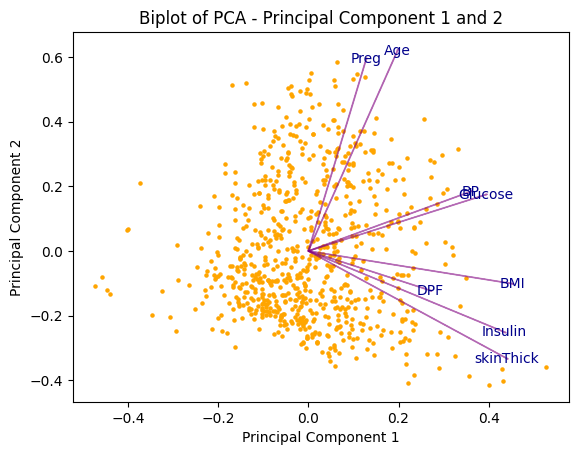

<Figure size 640x480 with 0 Axes>

In [72]:
component_x = 1 # principal component 1
component_y = 2 # principal component 2

plt.title('Biplot of PCA - Principal Component {} and {}'.format(component_x, component_y))

biplot(component_x=component_x, 
       component_y=component_y, 
       pca_features=top3_pca_features,
       loadings=np.transpose(pca_new.components_),
       labels=list(numerical_features))

### Interpreting the Biplot

* Orange dots specify all the 768 data points and their scaled values on the PC1 and PC2 dimensions
    * The data is fairly evenly distributed across both components with no specific pattern of a relationship that is visibly discernible
    * The random distribution of data is an indication of a good dimensionality reduction
* Most of the features are positively associated with Principal Component 1
    * BMI, Insulin, skinThick have the highest association with Principal Component 1
    * Followed by Glucose and BP
    * Preg and Age are least associated with Principal Component 1
* Features are either positively or negatively associated with Principal Component 2
    * Age and Preg are highly positively associated with Principal Component 2
    * skinThick and Insulin are highly negatively associated with Principal Component 2

Biplots are also useful to learn how features are correlated:
* A small angle indicates positive correlation
    * Ex. Glucose and BP are highly positively correlated; Preg and Age are highly correlated;
* A 90 degrees angle indicates orthogonality - almost no correlation
    * Ex. Age and BMI are not correlated
* A large angle indicates negative correlation
    * Ex. Preg and skinThick are negatively correlated; Age and Insulin are negatively correlated

Ref: https://bioturing.medium.com/how-to-read-pca-biplots-and-scree-plots-186246aae063


#### Biplot of Principal Components 1 and 3

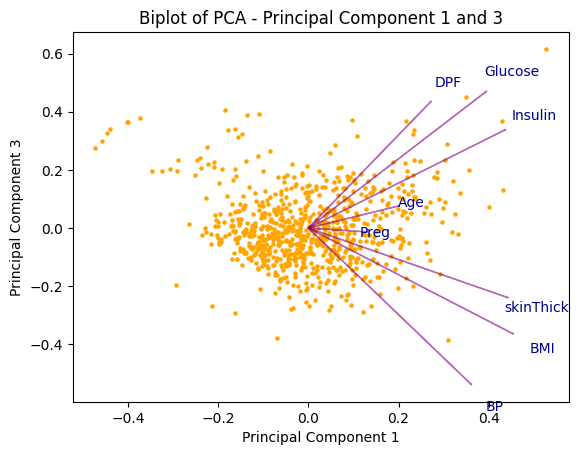

<Figure size 640x480 with 0 Axes>

In [51]:
component_x = 1 
component_y = 3

plt.title('Biplot of PCA - Principal Component {} and {}'.format(component_x, component_y))

biplot(component_x=component_x, 
       component_y=component_y, 
       pca_features=top3_pca_features,
       loadings=np.transpose(pca_new.components_),
       labels=list(numerical_features))

## Using PCA in classification

In [59]:
# We have already scaled X_train and X_test earlier - please refer to this 
pca_model = PCA(
    n_components=3, # only looking at the top 3 components as identified above based on Elbow Rule and validated by Kaiser Criterion
    random_state=12345,
    )
X_train_pca = pca_model.fit_transform(X_train)
X_test_pca = pca_model.transform(X_test)

In [60]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=50, random_state=0)
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)

print("Accuracy of the RandomForest Classifier on dimensionality reduced data using only 3 principal components is: {:2%}".format(round(accuracy_score(y_test, y_pred),4)))

Accuracy of the RandomForest Classifier on dimensionality reduced data using only 3 principal components is: 75.320000%


### The output shows that with less than half number of features, a performance difference of ~5% is observed (from 80.52% to 75.32%).

### In other words, with 3 principal components, you get an accuracy of around 75% so the extra 5 sets of features only contribute to an increase of around 4% in accuracy.


